Analyzing serial vs shuffle, now finding possibly 

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
from utils import get_logs_and_files, convert_train_to_test_idx
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange


# Factorized experiments

In [2]:
experiments = [ 'shuffle_add', 'shuffle_mul', 'random_gates_add', 'random_gates_mul',]
experiments = [  'shuffle_mul','random_gates_mul','shuffle_add','random_gates_add','random_gates_both',]
experiments = [ 'shuffle_mul', 'random_gates_mul']
folder_name = './../files/controls/'
folder_name = './../files/prob_rehearsal/'
folder_name = './../files/forgetting_measure/'
folder_name = './../files/forgetting_measure_14_tasks/'
folder_name = './../files/forgetting_measure_14_tasks_fixed_to_crit/'
folder_name = './../files/forgetting_measure_14_tasks_fixed_to_crit_equal_training/'


In [88]:
exps = experiments
accuracy_dict = {}
total_trials_dict={}
novel_and_rehearsal_totals_dict = {}
novel_and_rehearsal_ttcs_dict = {}
forgettings_dict = {}
average_acc_dict = {}
for exp_name in exps:
    testing_logs, test_files = get_logs_and_files(folder_name, exp_name, file_sig='testing_log')
    training_logs, train_files = get_logs_and_files(folder_name, exp_name, file_sig='training_log')
    configs, config_files = get_logs_and_files(folder_name, exp_name, file_sig='config')
    mean_accuracies = []
    totals = []
    novel_and_rehearsal_totals = []
    novel_and_rehearsal_ttcs = []
    forgettings = []
    average_acc =[]
    for (testing_log, training_log,config) in (zip(testing_logs, training_logs, configs)):
        final_accuracy_average = np.mean(list(testing_log.accuracies[-1].values()))
        mean_accuracies.append(final_accuracy_average)
        totals.append(testing_log.total_batches)
        novel_and_rehearsal_totals.append(testing_log.stamps[-1] - testing_log.start_testing_at)
        novel_reh_novel_no_of_tasks = 16
        novel_and_rehearsal_ttcs.append(training_log.trials_to_crit[-novel_reh_novel_no_of_tasks:])
        means = [np.mean(get_negative_and_absolute_acc_changes_after_learning(ti)[1] )for ti in range(2,len(training_log.switch_task_id)-1)]
        forgettings.append(means)
        # avg
        taa = []
        for logi in range(15):
            taa.append([test_acc[logi] for test_acc in testing_log.accuracies])
        average_acc.append(np.stack(taa))
        
    accuracy_dict.update({exp_name: np.stack(mean_accuracies)})
    total_trials_dict.update({exp_name: np.stack(totals)})
    novel_and_rehearsal_totals_dict.update({exp_name: np.stack(novel_and_rehearsal_totals)})
    novel_and_rehearsal_ttcs_dict.update({exp_name: np.stack(novel_and_rehearsal_ttcs)})
    average_acc_dict.update({exp_name: (average_acc)})
    forgettings_dict.update({exp_name: np.stack(forgettings)})

In [85]:
forgettings_dict[exp_name][np.isnan(forgettings_dict[exp_name])] =0.

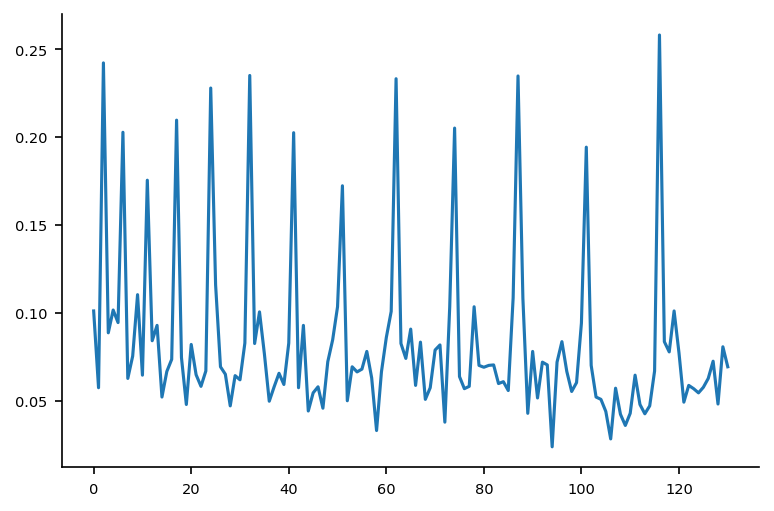

In [89]:
plt.plot(forgettings_dict[exp_name].mean(0))

In [16]:
task_order = -15

In [62]:
end_of_previous = training_log.switch_trialxxbatch[task_order] - 1 # the switch_trialxxbatch marks begning of task.
testing_stamp_before = convert_train_to_test_idx(training_log, testing_log, end_of_previous) 
end_of_task = training_log.switch_trialxxbatch[task_order] + training_log.trials_to_crit[task_order] 
testing_stamp_after = convert_train_to_test_idx(training_log, testing_log, end_of_task) 

# get accuracies exluding the accs for the current task.
test_idx = testing_stamp_before
accs_before = [testing_log.accuracies[test_idx][idx] for idx in testing_log.accuracies[test_idx].keys() if not idx == training_log.task_ids[task_order]]
test_idx = testing_stamp_after
accs_after = [testing_log.accuracies[test_idx][idx] for idx in testing_log.accuracies[test_idx].keys() if not idx == training_log.task_ids[task_order]]

diffs = np.array(accs_after) - np.array(accs_before)
negatives = diffs[diffs<0.] # get only change in accuracy where forgetting happened. 
absolutes = np.abs(diffs) # get the absolute changes, as a measure of interference.

print(f'after  \t before \t change')
for a, b in zip(accs_after, accs_before):
    print(f'{a:0.2f}  \t {b:0.2f} \t {a-b:0.2f}')

after  	 before 	 change
0.97  	 0.97 	 0.00
0.70  	 0.77 	 -0.07
0.50  	 0.40 	 0.10
0.73  	 0.67 	 0.07
0.43  	 0.63 	 -0.20
0.47  	 0.53 	 -0.07
0.80  	 0.70 	 0.10
0.63  	 0.50 	 0.13
0.80  	 0.80 	 0.00
0.87  	 0.80 	 0.07
1.00  	 0.63 	 0.37
0.67  	 0.47 	 0.20
0.67  	 0.10 	 0.57
0.77  	 0.47 	 0.30


In [87]:
def get_negative_and_absolute_acc_changes_after_learning(task_order):
    end_of_previous = training_log.switch_trialxxbatch[task_order] - 1 # the switch_trialxxbatch marks begning of task.
    testing_stamp_before = convert_train_to_test_idx(training_log, testing_log, end_of_previous) 
    end_of_task = training_log.switch_trialxxbatch[task_order] + training_log.trials_to_crit[task_order] 
    testing_stamp_after = convert_train_to_test_idx(training_log, testing_log, end_of_task) 

    # get accuracies exluding the accs for the current task.
    test_idx = testing_stamp_before
    accs_before = [testing_log.accuracies[test_idx][idx] for idx in testing_log.accuracies[test_idx].keys() if not idx == training_log.task_ids[task_order]]
    test_idx = testing_stamp_after
    accs_after = [testing_log.accuracies[test_idx][idx] for idx in testing_log.accuracies[test_idx].keys() if not idx == training_log.task_ids[task_order]]

    diffs = np.array(accs_after) - np.array(accs_before)
    negatives = diffs[diffs<0.] # get only change in accuracy where forgetting happened. 
    if len(negatives) < 1:
        negatives = np.array([0]) # otherwise you will get nan when you take means later.
    absolutes = np.abs(diffs) # get the absolute changes, as a measure of interference.
    return(negatives, absolutes)

In [69]:
negs, absolutes = get_negative_and_absolute_acc_changes_after_learning(-13)
print(negs)

[-0.3        -0.10000002 -0.03333336 -0.10000002 -0.0333333 ]


/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


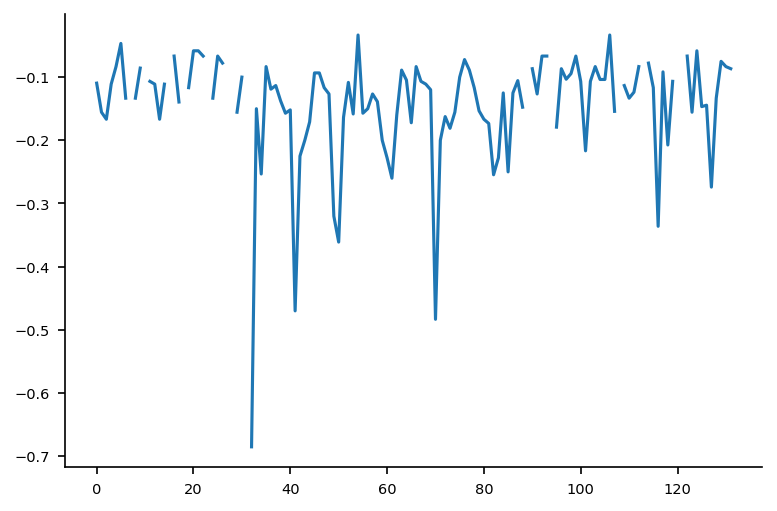

In [71]:
means = [np.mean(get_negative_and_absolute_acc_changes_after_learning(ti)[0] )for ti in range(2,len(training_log.switch_task_id))]
plt.plot(means)

In [27]:
end_of_previous = training_log.switch_trialxxbatch[task_order] - 1 # the switch_trialxxbatch marks begning of task.
testing_stamp_before = convert_train_to_test_idx(training_log, testing_log, end_of_previous) 
end_of_task = training_log.switch_trialxxbatch[task_order] + training_log.trials_to_crit[task_order] 
testing_stamp_after = convert_train_to_test_idx(training_log, testing_log, end_of_task) 

print (f'training before: {end_of_previous}')
print (f'stamp before: {testing_stamp_before}')
# stamp_after = convert_train_to_test_idx(training_log, testing_log, training_log.switch_trialxxbatch[-16])
print (f'training after : {end_of_task}')
print (f'stamp after: {testing_stamp_after}')


training before: 9037
stamp before: 1002
training after : 9051
stamp after: 1005


In [28]:
training_idx = end_of_previous
test_idx = training_log.stamps[training_idx]
diff_arra = np.abs(np.array(testing_log.stamps) - test_idx)
test_t_idx = np.argmin(diff_arra)
print(test_t_idx)

1002


In [48]:
train_idx = training_log.stamps[training_idx] # really does not do anything. one to one corr
diff_arra = np.abs(np.array(testing_log.stamps) - train_idx)
test_t_idx = np.argmin(diff_arra)
test_idx = test_t_idx
print(diff_arra[-60:])
print(test_idx)

[ 48  38  28  18   8   1   2  12  15  22  31  32  42  52  62  72  80  82
  92 101 102 112 116 122 132 142 147 152 162 167 172 182 192 193 202 212
 222 232 242 252 260 262 272 281 282 292 302 304 312 322 332 336 342 352
 362 372 382 392 402 404]
1002


In [42]:
print(training_log.task_ids[task_order])

4


In [55]:
test_idx = testing_stamp_after
accs_after = [testing_log.accuracies[test_idx][idx] for idx in testing_log.accuracies[test_idx].keys() if not idx == training_log.task_ids[task_order]]
test_idx = testing_stamp_before
accs_before = [testing_log.accuracies[test_idx][idx] for idx in testing_log.accuracies[test_idx].keys() if not idx == training_log.task_ids[task_order]]
# print(np.mean(accs))

In [58]:
for a, b in zip(accs_after, accs_before):
    print(f'{a:0.2f}  \t {b:0.2f} \t {a-b:0.2f}')

0.97  	 0.97 	 0.00
0.70  	 0.77 	 -0.07
0.50  	 0.40 	 0.10
0.73  	 0.67 	 0.07
0.43  	 0.63 	 -0.20
0.47  	 0.53 	 -0.07
0.80  	 0.70 	 0.10
0.63  	 0.50 	 0.13
0.80  	 0.80 	 0.00
0.87  	 0.80 	 0.07
1.00  	 0.63 	 0.37
0.67  	 0.47 	 0.20
0.67  	 0.10 	 0.57
0.77  	 0.47 	 0.30


In [32]:
print(testing_log.stamps[-60:])

[8989, 8999, 9009, 9019, 9029, 9038, 9039, 9049, 9052, 9059, 9068, 9069, 9079, 9089, 9099, 9109, 9117, 9119, 9129, 9138, 9139, 9149, 9153, 9159, 9169, 9179, 9184, 9189, 9199, 9204, 9209, 9219, 9229, 9230, 9239, 9249, 9259, 9269, 9279, 9289, 9297, 9299, 9309, 9318, 9319, 9329, 9339, 9341, 9349, 9359, 9369, 9373, 9379, 9389, 9399, 9409, 9419, 9429, 9439, 9441]


In [22]:
training_log.trials_to_crit[task_order]
training_log.switch_trialxxbatch[task_order]

9038

In [13]:

np.mean(list(testing_log.accuracies[stamp_after].values()))

0.84888893

In [19]:
testing_log.accuracies[374]

defaultdict(None,
            {0: array(0.90000004, dtype=float32),
             1: array(1., dtype=float32),
             2: array(0.6333334, dtype=float32),
             3: array(0.90000004, dtype=float32),
             4: array(0.6333334, dtype=float32),
             5: array(0.90000004, dtype=float32),
             6: array(0.9333334, dtype=float32),
             7: array(0.6, dtype=float32),
             8: array(0.73333335, dtype=float32),
             9: array(0.6333334, dtype=float32),
             10: array(1., dtype=float32),
             11: array(0.06666667, dtype=float32),
             12: array(0.7666667, dtype=float32),
             13: array(1., dtype=float32),
             14: array(0.7666667, dtype=float32)})

In [21]:
config.tasks_id_name

[(3, 'yang19.dm1-v0'),
 (10, 'yang19.rtanti-v0'),
 (6, 'yang19.dmc-v0'),
 (8, 'yang19.ctxdm2-v0'),
 (1, 'yang19.rtgo-v0'),
 (13, 'yang19.dnms-v0'),
 (0, 'yang19.go-v0'),
 (7, 'yang19.dm2-v0'),
 (4, 'yang19.ctxdm1-v0'),
 (12, 'yang19.dlyanti-v0'),
 (14, 'yang19.dnmc-v0'),
 (2, 'yang19.dlygo-v0'),
 (5, 'yang19.dms-v0'),
 (9, 'yang19.multidm-v0'),
 (11, 'yang19.anti-v0')]

In [25]:
learned_tasks = [idn[0] for idn in config.tasks_id_name[:-1]] # get the task_ids excluding the last novel one
[testing_log.accuracies[374][idx] for idx in learned_tasks]

[array(0.90000004, dtype=float32),
 array(1., dtype=float32),
 array(0.9333334, dtype=float32),
 array(0.73333335, dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(0.90000004, dtype=float32),
 array(0.6, dtype=float32),
 array(0.6333334, dtype=float32),
 array(0.7666667, dtype=float32),
 array(0.7666667, dtype=float32),
 array(0.6333334, dtype=float32),
 array(0.90000004, dtype=float32),
 array(0.6333334, dtype=float32)]

Text(0, 0.5, 'Novel&reh batches (100 trials)')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


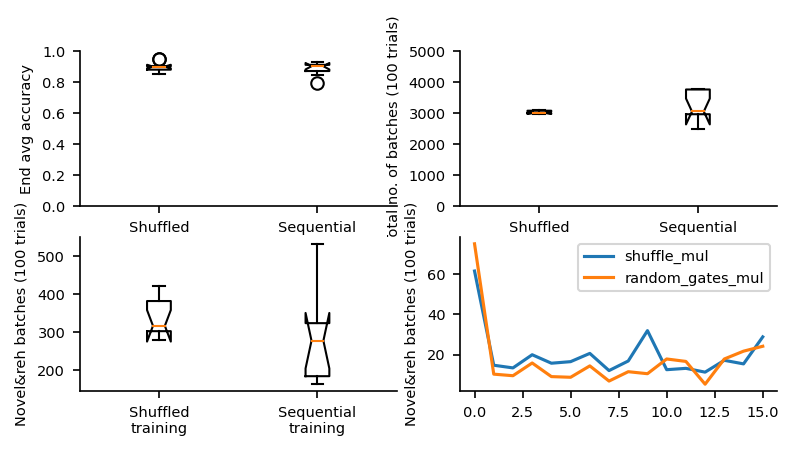

In [4]:
exps_names=  experiments
exps_names = [ 'Shuffled\ntraining', 'Sequential\ntraining',]
fig, axes = plt.subplots(2,2, figsize=[6,3])
ax = axes[0,0]
_=ax.boxplot([accuracy_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('End avg accuracy')
ax.set_ylim([0,1])

ax = axes[0,1]
_=ax.boxplot([total_trials_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Total no. of batches (100 trials)')
ax.set_ylim([0, 5000])

ax = axes[1,0]
_=ax.boxplot([novel_and_rehearsal_totals_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Novel&reh batches (100 trials)')

ax = axes[1,1]
ttcs = ([np.vstack(novel_and_rehearsal_ttcs_dict[exp]).mean(0) for exp in exps])
ax.plot(ttcs[0], label=exps[0])
ax.plot(ttcs[1], label=exps[1])
ax.legend()
# _=ax.boxplot([novel_and_rehearsal_ttcs_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Novel&reh batches (100 trials)')

In [24]:
ttcs[0].shape

(16,)

(0.0, 1.0)

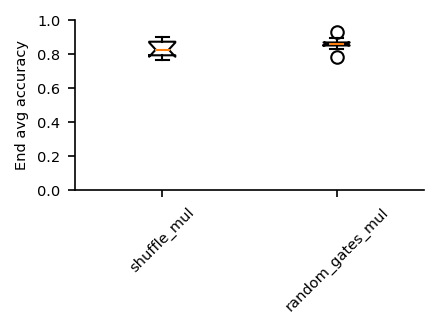

In [8]:

fig, (ax) = plt.subplots(1,1, figsize=[3,1.5])
_=ax.boxplot([accuracy_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
_=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('End avg accuracy')
ax.set_ylim([0,1])
# plt.savefig('./files/end_accuracy_box_plots.jpg',dpi=300)

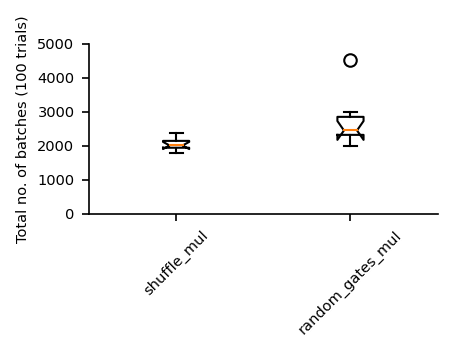

In [7]:
fig, (ax) = plt.subplots(1,1, figsize=[3,1.5])
_=ax.boxplot([total_trials_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
_=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Total no. of batches (100 trials)')
ax.set_ylim([0, 5000])
plt.savefig('./files/total_batches_box_plots.jpg',dpi=300)

NameError: name 'exps' is not defined

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


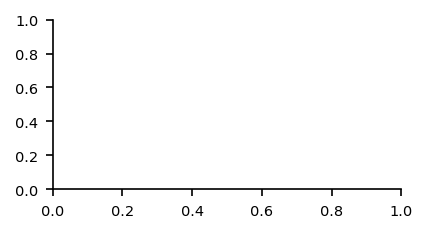

In [3]:
fig, (ax) = plt.subplots(1,1, figsize=[3,1.5])
_=ax.boxplot([novel_and_rehearsal_totals_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
_=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('')
# ax.set_ylim([0, 5000])
# plt.savefig('./files/_total_batches_box_plots.jpg',dpi=300)

average_acc_dict is a dict of keys experiment name. Returns a list of np arrays with accuracies from all tasks. Still need to average them [no_tasks, tstamps]


In [ ]:
def get_ttc_rehearsals(logs, rehearsal_no):
    rehearsal_data=[]
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
    return(np.stack(rehearsal_data))


In [ ]:
logs, lifiles = get_logs_and_files(folder_name, 'shuffle_add', file_sig='training_log',  search_strs=['tasks_10'])
def new_get_rehearsals(logs, rehearsal_no=1):

    # print('swtch \ttid \t rehNo \t ttc \t order')
    rehearsal_ttcs = []
    for log in logs:
        times_seen = []
        order_learned = []
        ttc = []
        np_task_id = np.array(log.switch_task_id)
        np_stamps = log.switch_trialxxbatch + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch)):
            times_seen.append( np.sum( np_task_id[:i]== log.switch_task_id[i]))
            order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
    # for i in (range(12)):
        # print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    
    return( np.stack(rehearsal_ttcs) )

rt = new_get_rehearsals(logs, 1)

In [ ]:
log = logs[0]
T = len(log.switch_trialxxbatch)
first_serial_block= (np.array(logs[0].trials_to_crit)> 1).argmax()
# first_serial_block= T - 8
print ('switch_trial\t task_id\t ttc\t first')
for ti in range(T-10, T):
    print (f'{log.switch_trialxxbatch[ti]}\t\t {log.switch_task_id[ti]}\t\t {log.trials_to_crit[ti]}\t', f'{1 if (first_serial_block==ti) else 0}')

switch_trial	 task_id	 ttc	 first
1298		 6		 1	 0
1299		 3		 1	 0
1299		 10		 22	 1
1321		 11		 14	 0
1335		 10		 12	 0
1347		 11		 11	 0
1358		 12		 28	 0
1386		 10		 11	 0
1397		 11		 12	 0
1409		 12		 12	 0


(0.0, 1.0)

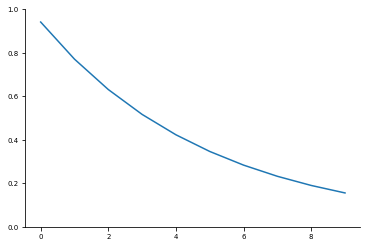

In [31]:
x = np.arange(0, 10, 1)
func = np.exp(-0.2*(x+.3))
# func = 0.9 * (1-x) + 0.1 * x
plt.plot(x, func)
plt.gca().set_ylim([0,1])

In [41]:
tasks = list(range(15))
task_sub_seqs = [[config.tasks_id_name[i] for i in range(s) if np.random.uniform() < np.exp(-0.1*((s-i)+.3))+0.1] for s in range(2, args.num_of_tasks+1)] # interleave tasks and add one task at a time
ts = [[tasks[i] for i in range(s) if np.random.uniform() < np.exp(-0.1*((s-i)+.3))+0.1] for s in range(2,len(tasks))]
ts = [[tasks[i] for i in range(s) if np.random.uniform()-0.1 < np.exp(-0.1*((s-i)+.3))] for s in range(2,len(tasks))]
# ts = [[tasks[i] for i in range(s) if np.random.uniform()< np.exp(-0.1*(s-i))] for s in range(2,len(tasks))]
print(ts)

[[0, 1], [0, 1, 2], [1, 2, 3], [1, 2, 3, 4], [0, 3, 4, 5], [3, 4, 5, 6], [2, 3, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7, 8], [1, 3, 4, 5, 6, 7, 8, 9], [0, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 4, 6, 7, 8, 9, 10, 11], [2, 4, 5, 8, 9, 11, 12], [5, 7, 8, 9, 12, 13]]


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


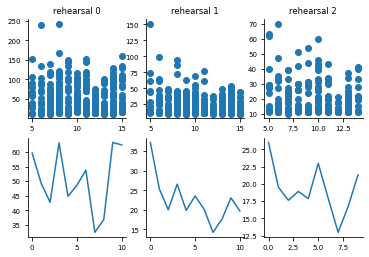

In [4]:
exp_name = 'shuffle_add'
rehearsal_ttcs = []
global_times_seen = []
order_learned = []
ttc = []
for no_tasks in range(4,14):
    logs, lifiles = get_logs_and_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
    # print('swtch \ttid \t rehNo \t ttc \t order')
    for log in logs:
        times_seen = []
        first_serial_block= (np.array(log.trials_to_crit)> 1).argmax()
        np_task_id = np.array(log.switch_task_id[first_serial_block:])
        np_stamps = log.switch_trialxxbatch[first_serial_block:] + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch[first_serial_block:])):
            times_seen.append( np.sum( np_task_id[:i]== np_task_id[i]))
            order_learned.append(no_tasks+ np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        # rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
        global_times_seen += times_seen
rehearsal_no = 0
fttc = np.array(ttc)[np.array(global_times_seen)==rehearsal_no]
forder_learned = np.array(order_learned)[np.array(global_times_seen)==rehearsal_no]
fig, axes = plt.subplots(2,3)

for i in range(3):
    ax = axes[0,i]
    rehearsal_no = i
    fttc = np.array(ttc)[np.array(global_times_seen)==rehearsal_no]
    forder_learned = np.array(order_learned)[np.array(global_times_seen)==rehearsal_no]
    ax.scatter(forder_learned, fttc)
    ax.set_title(f'rehearsal {rehearsal_no}')

    ax = axes[1,i]
    ax.plot([np.mean(np.array(fttc)[np.array(forder_learned) == ol]) for ol in np.unique(forder_learned)])


#### Speared focused analysis of first learning

-8 new task  
-7 another new task2  
-6 1st rehearsal 
-5 task2 reh (1st rehearsal) 
-4 task3
-3 2nd rehearsal 
-2 task2 2nd rehearsal (2nd rehearsal) 

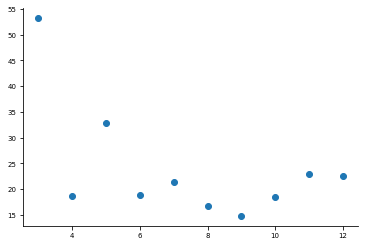

In [5]:
ttc_pick = -1
exp_name = 'shuffle_add'
order_learned = []
ttc = []
for no_tasks in range(3,13):
    logs, lifiles = get_logs_and_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
    # print('swtch \ttid \t rehNo \t ttc \t order')
    ttc_task_1 = []
    for log in logs:
        ttc_task_1.append(log.trials_to_crit[ttc_pick]) # This is the the first task learned.
    ttc.append(ttc_task_1)
    order_learned.append(no_tasks)

# fig, axes = plt.subplots(2,3)

plt.scatter(order_learned, [np.mean(tt) for tt in ttc])



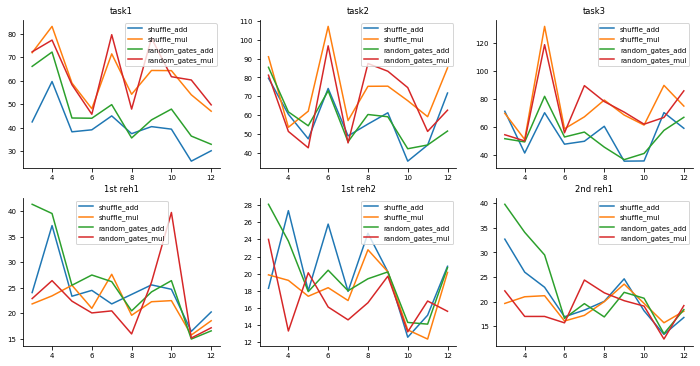

In [12]:
def focused_ttc(exp_name, ttc_pick=-8):
    order_learned = []
    ttc = []
    for no_tasks in range(3,13):
        logs, lifiles = get_logs_and_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
        # print('swtch \ttid \t rehNo \t ttc \t order')
        ttc_task_1 = []
        for log in logs:
            ttc_task_1.append(log.trials_to_crit[ttc_pick]) # This is the the first task learned.
        ttc.append(ttc_task_1)
        order_learned.append(no_tasks)
    return (order_learned, ttc) # order learned is simple range(3,13), ttc is ttc data grouped by no_tasks [no_tasks, runs]

fig, axes = plt.subplots(2,3, figsize =[12,6])
axi=0
names = ['task1','task2', 'task3', '1st reh1', '1st reh2','2nd reh1']
for ttc_pick in [-8,-7, -4, -6, -5,-3]:
    for en in (experiments):
        order_learned, ttc = focused_ttc(exp_name =en, ttc_pick= ttc_pick)
        ax = axes.flatten()[axi]
        ax.set_title(names[axi])
        ax.plot(order_learned, [np.mean(tt) for tt in ttc], label=en)
        # _=plt.boxplot( ttc)
    ax.legend()
    axi += 1

plt.savefig('./files/spear_focused_analysis.jpg', dpi=300)


SO now I have three arrays:
times_seen
order_learned
ttc

I need to filter ttc based on times_seen: no of rehearsal interested in, really 0, 1, 2
and bin them by order_learned from 3 - 14





In [39]:
exp_name = 'random_gates_mul'
rehearsal_ttcs = []

global_times_seen = []
order_learned = []
ttc = []
    
for no_tasks in range(4,13):
    logs, lifiles = get_logs_and_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
    
    # print('swtch \ttid \t rehNo \t ttc \t order')
    for log in logs:
        times_seen = []
        first_serial_block= max( len(log.trials_to_crit)-8 , (np.array(log.trials_to_crit)> 1).argmax())
        np_task_id = np.array(log.switch_task_id[first_serial_block:])
        np_stamps = log.switch_trialxxbatch[first_serial_block:] + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch[first_serial_block:])):
            times_seen.append( np.sum( np_task_id[:i]== np_task_id[i]))
            order_learned.append(no_tasks+ np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        # rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
        global_times_seen += times_seen
    for i in (range(8)):
        print(np_stamps[i], '\t', np_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    
    # return( np.stack(rehearsal_ttcs) )

# rt = new_get_rehearsals(logs, 1)

485 	 11 	 0 	 11 	 5
498 	 9 	 0 	 11 	 6
515 	 14 	 0 	 24 	 7
574 	 2 	 0 	 72 	 8
609 	 11 	 1 	 11 	 5
621 	 9 	 1 	 11 	 6
687 	 14 	 1 	 13 	 7
712 	 2 	 1 	 24 	 8
704 	 14 	 0 	 11 	 5
717 	 2 	 0 	 11 	 6
729 	 13 	 0 	 24 	 7
931 	 11 	 0 	 72 	 8
951 	 9 	 0 	 11 	 5
1029 	 14 	 1 	 11 	 6
1094 	 2 	 1 	 13 	 7
1148 	 13 	 1 	 24 	 8
953 	 13 	 0 	 11 	 5
965 	 0 	 0 	 11 	 6
990 	 11 	 0 	 24 	 7
1002 	 9 	 0 	 72 	 8
1020 	 14 	 0 	 11 	 5
1037 	 2 	 0 	 11 	 6
1063 	 13 	 1 	 13 	 7
1075 	 0 	 1 	 24 	 8
979 	 10 	 0 	 11 	 5
999 	 11 	 0 	 11 	 6
1010 	 9 	 0 	 24 	 7
1033 	 14 	 0 	 72 	 8
1045 	 2 	 0 	 11 	 5
1057 	 13 	 0 	 11 	 6
1069 	 0 	 0 	 13 	 7
1080 	 10 	 1 	 24 	 8
1439 	 11 	 0 	 11 	 5
1451 	 9 	 0 	 11 	 6
1477 	 14 	 0 	 24 	 7
1489 	 2 	 0 	 72 	 8
1530 	 13 	 0 	 11 	 5
1545 	 0 	 0 	 11 	 6
1556 	 10 	 0 	 13 	 7
1569 	 1 	 0 	 24 	 8
1377 	 9 	 0 	 11 	 5
1401 	 14 	 0 	 11 	 6
1412 	 2 	 0 	 24 	 7
1424 	 13 	 0 	 72 	 8
1437 	 0 	 0 	 11 	 5
1448

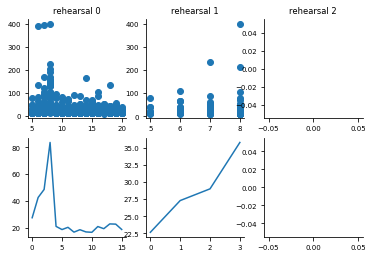

In [36]:
fig, axes = plt.subplots(2,3)
for i in range(3):
    ax = axes[0,i]
    rehearsal_no = i
    fttc = np.array(ttc)[np.array(global_times_seen)==rehearsal_no]
    forder_learned = np.array(order_learned)[np.array(global_times_seen)==rehearsal_no]
    ax.scatter(forder_learned, fttc)
    ax.set_title(f'rehearsal {rehearsal_no}')

    ax = axes[1,i]
    ax.plot([np.mean(np.array(fttc)[np.array(forder_learned) == ol]) for ol in np.unique(forder_learned)])


In [ ]:
logs, lifiles = get_logs_and_files(folder_name, 'shuffle_add', file_sig='training_log',  search_strs=['tasks_10'])
def new_get_rehearsals(logs, rehearsal_no=1):

    # print('swtch \ttid \t rehNo \t ttc \t order')
    rehearsal_ttcs = []
    for log in logs:
        times_seen = []
        order_learned = []
        ttc = []
        np_task_id = np.array(log.switch_task_id)
        np_stamps = log.switch_trialxxbatch + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch)):
            times_seen.append( np.sum( np_task_id[:i]== log.switch_task_id[i]))
            order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
    # for i in (range(12)):
        # print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    
    return( np.stack(rehearsal_ttcs) )

rt = new_get_rehearsals(logs, 1
)

# Learned gates. Also variety of multi gates

In [2]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange

In [3]:
experiments = [  'random_gates_mul',]
folder_name = './../files/gates_mul_titrate_scale/'


In [5]:
def get_logs_and_files(data_folder, exp_name, file_sig='testing_log', search_strs=[]):
    lfiles = os.listdir(data_folder+f'{exp_name}/')
    lfiles = [fn for fn in lfiles if fn.__contains__(file_sig)]
    for sstr in search_strs:
        lfiles = [fn for fn in lfiles if fn.__contains__(sstr)]

    logs = []
    for fi, fn in enumerate(lfiles):
        try:
            logs.append(np.load(data_folder+f'{exp_name}/' + fn, allow_pickle=True).item())
        except:
            print('some problem with ', fn)
    return(logs, lfiles)

In [5]:
# search space
gates_means = [(x/10) for x in range(5,15, 2)]
gates_means.insert(3, 1.0) # gates_mean  Just added 10,
print(gates_means) 
gates_stds = [(x/10) for x in range(0,3, 1)] #gates_std  
gates_sparsities = [(x/10) for x in [3, 4,5,6,]] # 0 and 9 are also available gates_sparsity 
no_of_tasks = 14

## adding more nuance


signatures = [f'{gm:1.1f}_{gs:1.1f}_{gsp:1.1f}_' for gm in gates_means for gs in gates_stds for gsp in gates_sparsities]




[0.5, 0.7, 0.9, 1.0, 1.1, 1.3]


In [6]:
exps = experiments
train_total_batchs_dict= {}
test_train_total_batchs_dict= {}
train_end_accs_dict = {}
test_train_end_accs_dict = {}
novel_task_ttcs_dict = {}
old_tasks_ttcs_dict = {}
drop_accs_dict = {}

for exp_name in exps:
    for sig in signatures:
        logs, lfiles = get_logs_and_files(folder_name, exp_name, file_sig='testing_log', search_strs=[f'tasks_{no_of_tasks}_', sig])
        train_logs, lfiles = get_logs_and_files(folder_name, exp_name, file_sig='training_log', search_strs=[f'tasks_{no_of_tasks}_', sig])
        config_logs, config_files = get_logs_and_files(folder_name, exp_name, file_sig='config', search_strs=[f'tasks_{no_of_tasks}_', sig])
        if (len(logs)> 0):
            train_total_batchs= []
            test_train_total_batchs= []
            train_end_accs = []
            test_train_end_accs = []
            novel_task_ttcs = []
            old_tasks_ttcs = []
            drop_accs = []

            for log, train_log in zip(logs, train_logs):
                train_total_batchs.append(log.start_testing_at)
                test_train_total_batchs.append(log.stamps[-1] - log.start_testing_at)

                end_train = np.argmax(np.array(log.stamps) > log.start_testing_at) # find the closest testing point to start testing step_i
                
                train_end_accs.append(np.mean(list(log.accuracies[end_train].values())))
                test_train_end_accs.append(np.mean(list(log.accuracies[-1].values())))

                novel_task_ttcs.append(train_log.trials_to_crit[-no_of_tasks-1])
                old_tasks_ttcs.append (train_log.trials_to_crit[-no_of_tasks:])
                drop_accs.append( train_end_accs[-1] - np.mean(list(log.accuracies[end_train+novel_task_ttcs[-1]].values())) )# compare avg_acc end of train to end of training novel task
        
                
            # train_total_batchs_dict.update({exp_name+sig: np.stack(train_total_batchs)})
            # test_train_total_batchs_dict.update({exp_name+sig: np.stack(test_train_total_batchs)})
            # train_end_accs_dict .update({exp_name+sig: np.stack(train_end_accs)})
            # test_train_end_accs_dict .update({exp_name+sig: np.stack(test_train_end_accs)})
            # novel_task_ttcs_dict .update({exp_name+sig: np.stack(novel_task_ttcs)})
            # old_tasks_ttcs_dict .update({exp_name+sig: np.stack(old_tasks_ttcs)})
            # drop_accs_dict .update({exp_name+sig: np.stack(drop_accs)})

            train_total_batchs_dict.update({exp_name+sig:   np.stack(train_total_batchs).mean()})
            test_train_total_batchs_dict.update({exp_name+sig: np.stack(test_train_total_batchs).mean()})
            train_end_accs_dict .update({exp_name+sig: np.stack(train_end_accs).mean()})
            test_train_end_accs_dict .update({exp_name+sig: np.stack(test_train_end_accs).mean()})
            novel_task_ttcs_dict .update({exp_name+sig: np.stack(novel_task_ttcs).mean()})
            old_tasks_ttcs_dict .update({exp_name+sig: np.stack(old_tasks_ttcs).mean()})
            drop_accs_dict .update({exp_name+sig: np.stack(drop_accs).mean()})


In [7]:
config_logs, config_files = get_logs_and_files(folder_name, exp_name, file_sig='config', search_strs=[f'tasks_{no_of_tasks}_', signatures[3]])

In [8]:
len(train_total_batchs_dict.keys())

72

In [9]:
def get_min(test_dict):
    temp = min(test_dict.values())
    res = [key for key in test_dict if test_dict[key] == temp]
    return (res)
print(get_min(train_total_batchs_dict))

['random_gates_mul0.7_0.0_0.4_']


In [6]:
def get_values(dic_of_interest = train_total_batchs_dict):
    values = np.empty([len(gates_means), len(gates_stds), len(gates_sparsities), ])
    for m in range(len(gates_means)):
        for st in range(len(gates_stds)):
            for sp in range(len(gates_sparsities)):
                try:
                    values[m,st,sp] = dic_of_interest[exp_name+f'{gates_means[m]}_{gates_stds[st]}_{gates_sparsities[sp]}_']
                except KeyError:
                    values[m,st,sp] = np.nan
    return(values)
values= get_values(dic_of_interest = train_total_batchs_dict)

In [11]:
values = get_values(dic_of_interest=test_train_end_accs_dict)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


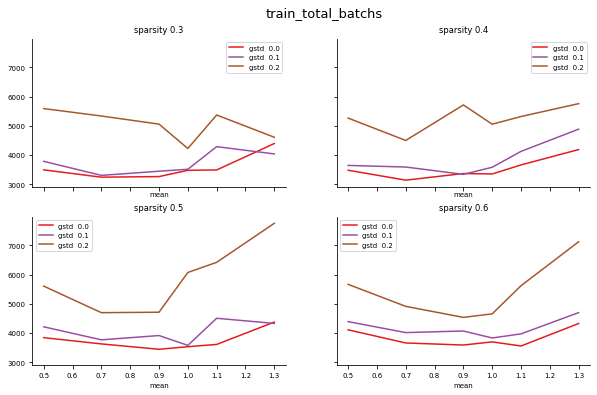

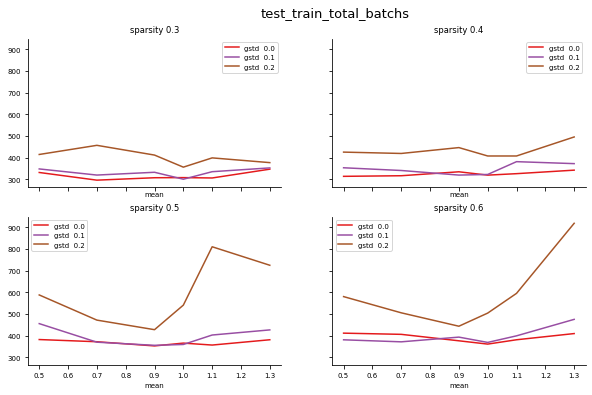

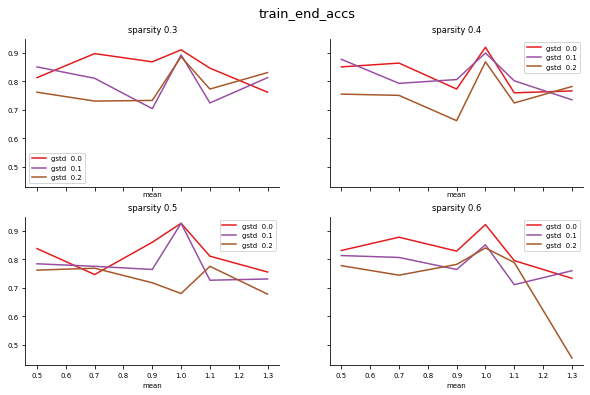

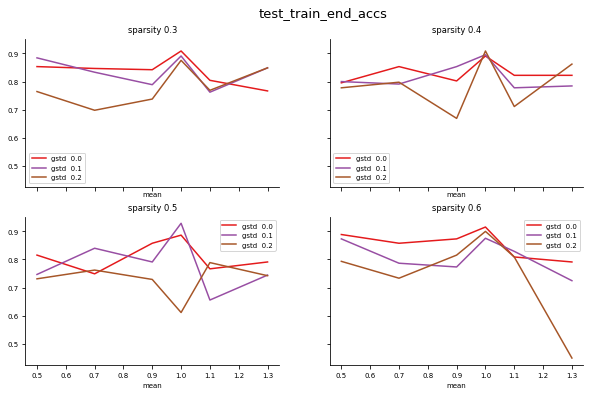

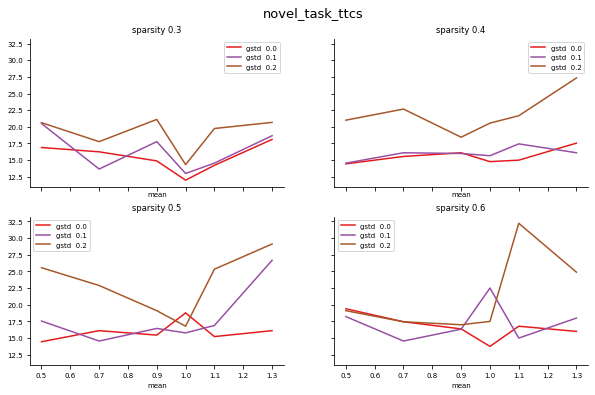

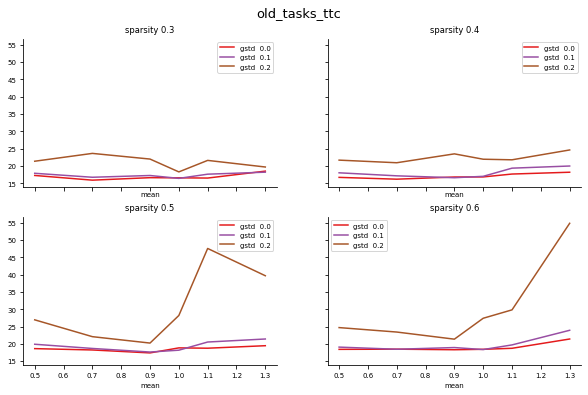

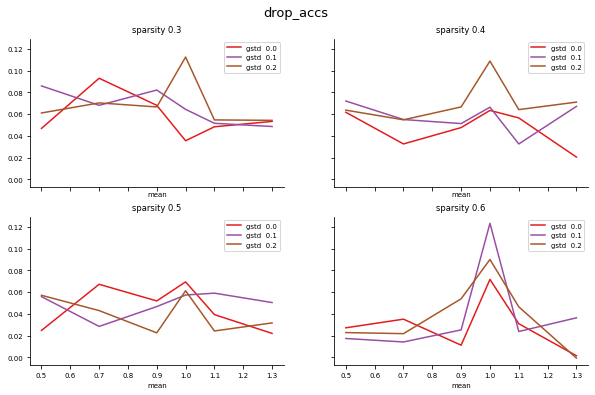

In [12]:
# Define Dataset
dics = {'train_total_batchs': train_total_batchs_dict,
'test_train_total_batchs': test_train_total_batchs_dict,
'train_end_accs': train_end_accs_dict ,
"test_train_end_accs": test_train_end_accs_dict ,
'novel_task_ttcs': novel_task_ttcs_dict ,
'old_tasks_ttc': old_tasks_ttcs_dict,
'drop_accs': drop_accs_dict}

x,y,z = gates_means, gates_stds, gates_sparsities

# Creating figure
for dic in dics:
    values =get_values(dics[dic])
    # ax = plt.axes(projection ="3d")
    color_map = plt.get_cmap('Set2')
    no_of_values = len(gates_stds)
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)


    fig, axes= plt.subplots(2,2, figsize = (10, 6), sharey=True, sharex=True)
    for sp in range(len(gates_sparsities)):
        ax = axes.flatten()[sp]
        for st in range(len(gates_stds)):
            ax.plot(gates_means, [values[m,st,sp] for m in range(len(gates_means))], label=f'gstd  {gates_stds[st]}', c=cmap.to_rgba(st),)
            ax.set_xlabel(f'mean')
            ax.set_title(f'sparsity {gates_sparsities[sp]}')
        ax.legend()
    axes[0,0].text(0.92, 1.15, dic, fontsize=13, transform=axes[0,0].transAxes)

    plt.savefig(f'./files/perf_{dic}.jpg', dpi=300)

3

In [55]:
experiments = [ 'shuffle_add', 'shuffle_mul', 'random_gates_add', 'random_gates_mul', 'random_gates_both']
# folder_name = './../files/gates_compare_learn/'
folder_name = './../files/gates_compare/'

# search space
gates_means = [(x/10) for x in [10]]
# gates_means.insert(3, 1.0) # gates_mean  Just added 10,
print(gates_means) 
gates_stds = [(x/10) for x in range(0,1, 1)] #gates_std  
# gates_sparsities = [(x/10) for x in range(0,6, 4)] # 0 and 9 are also available gates_sparsity 
gates_sparsities = [(x/10) for x in [4]] # 0 and 9 are also available gates_sparsity 
no_of_tasks = 14

## adding more nuance


signatures = [f'{gm:1.1f}_{gs:1.1f}_{gsp:1.1f}_' for gm in gates_means for gs in gates_stds for gsp in gates_sparsities]




[1.0]


In [56]:
signatures

['1.0_0.0_0.4_']

In [57]:
exps = experiments
accuracy_dict = {}
total_trials_dict={}
average_acc_dict = {}
for exp_name in exps:
    logs, lfiles = get_logs_and_files(folder_name, exp_name, file_sig='testing_log', search_strs=['tasks_14_'])
    mean_accuracies = []
    totals = []
    average_acc =[]
    for log in logs:
        final_accuracy_average = np.mean(list(log.accuracies[-1].values()))
        mean_accuracies.append(final_accuracy_average)
        totals.append(log.total_batches)
        
        # avg
        taa = []
        for logi in range(15):
            taa.append([test_acc[logi] for test_acc in log.accuracies])
        average_acc.append(np.stack(taa))
        
    accuracy_dict.update({exp_name: np.stack(mean_accuracies)})
    total_trials_dict.update({exp_name: np.stack(totals)})
    average_acc_dict.update({exp_name: (average_acc)})

In [63]:
exps = experiments
train_total_batchs_dict= {}
test_train_total_batchs_dict= {}
train_end_accs_dict = {}
test_train_end_accs_dict = {}
novel_task_ttcs_dict = {}
old_tasks_ttcs_dict = {}
drop_accs_dict = {}

for exp_name in exps:
    for sig in signatures:
        logs, lfiles = get_logs_and_files(folder_name, exp_name, file_sig='testing_log', search_strs=[f'tasks_{no_of_tasks}_', sig])
        train_logs, lfiles = get_logs_and_files(folder_name, exp_name, file_sig='training_log', search_strs=[f'tasks_{no_of_tasks}_', sig])
        config_logs, config_files = get_logs_and_files(folder_name, exp_name, file_sig='config', search_strs=[f'tasks_{no_of_tasks}_', sig])
        if (len(logs)> 0):
            train_total_batchs= []
            test_train_total_batchs= []
            train_end_accs = []
            test_train_end_accs = []
            novel_task_ttcs = []
            old_tasks_ttcs = []
            drop_accs = []

            for log, train_log in zip(logs, train_logs):
                train_total_batchs.append(log.start_testing_at)
                test_train_total_batchs.append(log.stamps[-1] - log.start_testing_at)

                end_train = np.argmax(np.array(log.stamps) > log.start_testing_at) # find the closest testing point to start testing step_i
                
                train_end_accs.append(np.mean(list(log.accuracies[end_train].values())))
                test_train_end_accs.append(np.mean(list(log.accuracies[-1].values())))

                novel_task_ttcs.append(train_log.trials_to_crit[-no_of_tasks-1])
                old_tasks_ttcs.append (train_log.trials_to_crit[-no_of_tasks:])
                drop_accs.append( train_end_accs[-1] - np.mean(list(log.accuracies[end_train+novel_task_ttcs[-1]].values())) )# compare avg_acc end of train to end of training novel task
        
                
            train_total_batchs_dict.update({exp_name+sig: np.stack(train_total_batchs)})
            test_train_total_batchs_dict.update({exp_name+sig: np.stack(test_train_total_batchs)})
            train_end_accs_dict .update({exp_name+sig: np.stack(train_end_accs)})
            test_train_end_accs_dict .update({exp_name+sig: np.stack(test_train_end_accs)})
            novel_task_ttcs_dict .update({exp_name+sig: np.stack(novel_task_ttcs)})
            old_tasks_ttcs_dict .update({exp_name+sig: np.stack(old_tasks_ttcs).mean(-1)})
            drop_accs_dict .update({exp_name+sig: np.stack(drop_accs)})


In [59]:
[exp for exp in dics[dic].keys()]

['shuffle_add1.0_0.0_0.4_',
 'shuffle_mul1.0_0.0_0.4_',
 'random_gates_add1.0_0.0_0.4_',
 'random_gates_mul1.0_0.0_0.4_',
 'random_gates_both1.0_0.0_0.4_']

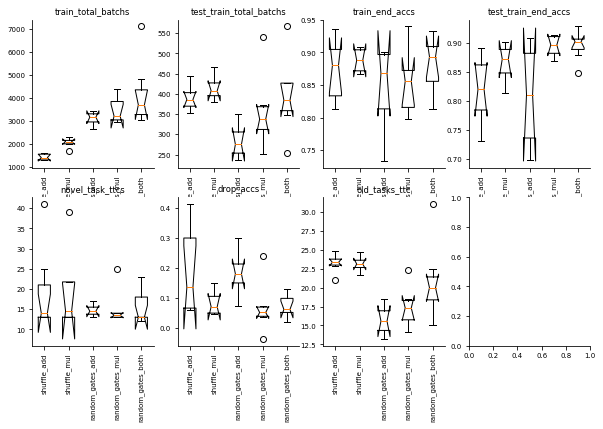

In [64]:
# Define Dataset
dics = {'train_total_batchs': train_total_batchs_dict,
'test_train_total_batchs': test_train_total_batchs_dict,
'train_end_accs': train_end_accs_dict ,
"test_train_end_accs": test_train_end_accs_dict ,
'novel_task_ttcs': novel_task_ttcs_dict ,
'drop_accs': drop_accs_dict,
'old_tasks_ttc': old_tasks_ttcs_dict,}

x,y,z = gates_means, gates_stds, gates_sparsities

# Creating figure
fig, axes= plt.subplots(2,4, figsize = (10, 6))
for di, dic in enumerate(dics):
    # values =get_values(dics[dic])
    # ax = plt.axes(projection ="3d")
    # color_map = plt.get_cmap('Set2')
    # no_of_values = len(gates_stds)
    # norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    # cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b tab20
    # cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    ax = axes.flatten()[di]
    _=ax.boxplot([dics[dic][exp] for exp in dics[dic].keys()], labels=[exp[:-(len('1.0_0.0_0.4_'))] for exp in dics[dic].keys()], meanline=True, notch=True)
    ax.set_title(dic)
    _=ax.set_xticklabels( [exp[:-(len('1.0_0.0_0.4_'))] for exp in dics[dic].keys()], rotation=90 )
# ax.set_ylabel('End avg accuracy')

    plt.savefig(f'./files/comps.jpg', dpi=300)

In [48]:
# _=ax.boxplot([dics[dic][exp] for exp in dics[dic].keys()], labels=[exp[:-(len('1.0_0.0_0.4_'))] for exp in dics[dic].keys()], meanline=True, notch=True)
# 
ot = dics[dic]

In [62]:

ot['shuffle_add1.0_0.0_0.4_'].shape

(7, 14)

(0.0, 5000.0)

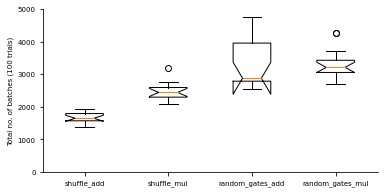

In [ ]:
fig, (ax) = plt.subplots(1,1, figsize=[6,3])
_=ax.boxplot([total_trials_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Total no. of batches (100 trials)')
ax.set_ylim([0, 5000])
# plt.savefig('./files/total_batches_box_plots.jpg',dpi=300)

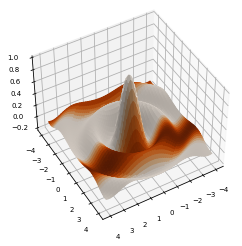

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# create some fake data
x = y = np.arange(-4.0, 4.0, 0.02)
x,y,z = gates_means, gates_stds, gates_sparsities
# here are the x,y and respective z values
X, Y = np.meshgrid(x, y)
Z = np.sinc(np.sqrt(X*X+Y*Y))
# this is the value to use for the color
V = np.sin(Y)

# create the figure, add a 3d axis, set the viewing angle
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,60)

# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
ax.plot_surface(X, Y, Z, facecolors=cm.Oranges(V))

average_acc_dict is a dict of keys experiment name. Returns a list of np arrays with accuracies from all tasks. Still need to average them [no_tasks, tstamps]


In [ ]:
def get_ttc_rehearsals(logs, rehearsal_no):
    rehearsal_data=[]
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
    return(np.stack(rehearsal_data))


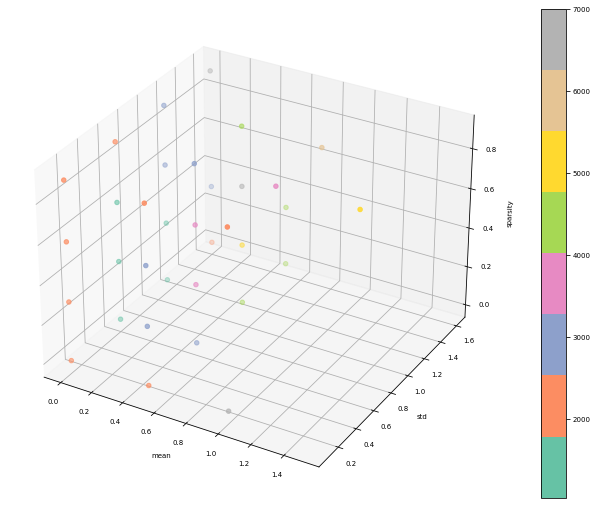

In [10]:
# Import libraries

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
# Define Dataset
x,y,z = gates_means, gates_stds, gates_sparsities

# Creating figure

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
  
# Creat color map

color_map = plt.get_cmap('Set2')
 
# Create scatter plot and colorbar

scatter_plot = ax.scatter3D(*np.meshgrid(x, y, z),
                            c=values,
                            cmap = color_map)
ax.set_xlabel('mean') ; ax.set_ylabel('std'); ax.set_zlabel('sparsity')
plt.colorbar(scatter_plot)

In [ ]:
logs, lifiles = get_logs_and_files(folder_name, 'shuffle_add', file_sig='training_log',  search_strs=['tasks_10'])
def new_get_rehearsals(logs, rehearsal_no=1):

    # print('swtch \ttid \t rehNo \t ttc \t order')
    rehearsal_ttcs = []
    for log in logs:
        times_seen = []
        order_learned = []
        ttc = []
        np_task_id = np.array(log.switch_task_id)
        np_stamps = log.switch_trialxxbatch + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch)):
            times_seen.append( np.sum( np_task_id[:i]== log.switch_task_id[i]))
            order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
    # for i in (range(12)):
        # print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    
    return( np.stack(rehearsal_ttcs) )

rt = new_get_rehearsals(logs, 1)

In [ ]:
log = logs[0]
T = len(log.switch_trialxxbatch)
first_serial_block= (np.array(logs[0].trials_to_crit)> 1).argmax()
# first_serial_block= T - 8
print ('switch_trial\t task_id\t ttc\t first')
for ti in range(T-10, T):
    print (f'{log.switch_trialxxbatch[ti]}\t\t {log.switch_task_id[ti]}\t\t {log.trials_to_crit[ti]}\t', f'{1 if (first_serial_block==ti) else 0}')

switch_trial	 task_id	 ttc	 first
1298		 6		 1	 0
1299		 3		 1	 0
1299		 10		 22	 1
1321		 11		 14	 0
1335		 10		 12	 0
1347		 11		 11	 0
1358		 12		 28	 0
1386		 10		 11	 0
1397		 11		 12	 0
1409		 12		 12	 0


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


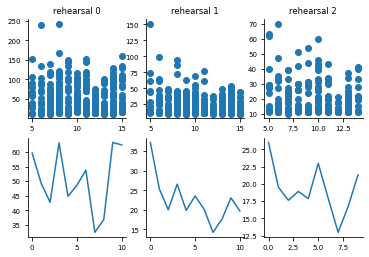

In [ ]:
exp_name = 'shuffle_add'
rehearsal_ttcs = []
global_times_seen = []
order_learned = []
ttc = []
for no_tasks in range(4,14):
    logs, lifiles = get_logs_and_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
    # print('swtch \ttid \t rehNo \t ttc \t order')
    for log in logs:
        times_seen = []
        first_serial_block= (np.array(log.trials_to_crit)> 1).argmax()
        np_task_id = np.array(log.switch_task_id[first_serial_block:])
        np_stamps = log.switch_trialxxbatch[first_serial_block:] + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch[first_serial_block:])):
            times_seen.append( np.sum( np_task_id[:i]== np_task_id[i]))
            order_learned.append(no_tasks+ np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        # rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
        global_times_seen += times_seen
rehearsal_no = 0
fttc = np.array(ttc)[np.array(global_times_seen)==rehearsal_no]
forder_learned = np.array(order_learned)[np.array(global_times_seen)==rehearsal_no]
fig, axes = plt.subplots(2,3)

for i in range(3):
    ax = axes[0,i]
    rehearsal_no = i
    fttc = np.array(ttc)[np.array(global_times_seen)==rehearsal_no]
    forder_learned = np.array(order_learned)[np.array(global_times_seen)==rehearsal_no]
    ax.scatter(forder_learned, fttc)
    ax.set_title(f'rehearsal {rehearsal_no}')

    ax = axes[1,i]
    ax.plot([np.mean(np.array(fttc)[np.array(forder_learned) == ol]) for ol in np.unique(forder_learned)])


#### Speared focused analysis of first learning

-8 new task  
-7 another new task2  
-6 1st rehearsal 
-5 task2 reh (1st rehearsal) 
-4 task3
-3 2nd rehearsal 
-2 task2 2nd rehearsal (2nd rehearsal) 

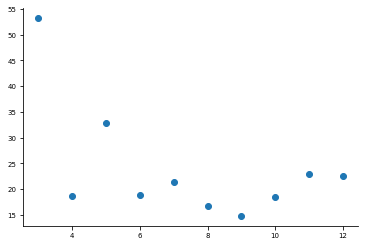

In [ ]:
ttc_pick = -1
exp_name = 'shuffle_add'
order_learned = []
ttc = []
for no_tasks in range(3,13):
    logs, lifiles = get_logs_and_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
    # print('swtch \ttid \t rehNo \t ttc \t order')
    ttc_task_1 = []
    for log in logs:
        ttc_task_1.append(log.trials_to_crit[ttc_pick]) # This is the the first task learned.
    ttc.append(ttc_task_1)
    order_learned.append(no_tasks)

# fig, axes = plt.subplots(2,3)

plt.scatter(order_learned, [np.mean(tt) for tt in ttc])

